# Riiid !
[Competition link](https://www.kaggle.com/c/riiid-test-answer-prediction)

First, some lectures to better understand the context !

* [The most important : arxiv paper](https://arxiv.org/abs/1912.03072)
* [An article about Ednet](https://www.koreatechdesk.com/korean-edutech-startup-riiid-becomes-santa-for-toeic-learners/)
* [Github code of EdNet (more informations about features)](https://github.com/riiid/ednet)

## <span style="color:green">train.csv<span style="color:darkblue">
### <span style="color:green">The variables :<span style="color:darkblue"> 

**<span style="color:darkblue">row_id</span>**: (int64) ID code for the row.

<span style="color:darkblue">**user_id**</span>: (int32) ID code for the user.
    
<span style="color:darkblue">**timestamp**</span>: (int64) the time in milliseconds between this user interaction and the first event completion from that user. <br>
<span style="color:crimson">**Continuous variable**</span>

    
<span style="color:darkblue">**user_answer**</span>: (int8) <br />
0, 1, 2, 3 if content_type_id == 0. -1 if content_type_id <br>
<span style="color:crimson">**Categorical variable**</span>


<span style="color:darkblue">**content_id**</span>: (int16) ID code for the user interaction

    
<span style="color:darkblue">**content_type_id**</span>: (int8) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.<br>
<span style="color:crimson">**Categorical variable**</span>

<span style="color:darkblue">**task_container_id**</span>: (int16) Id code for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a task_container_id.

<span style="color:darkblue">**prior_question_elapsed_time**</span>: (float32) The average time in milliseconds it took a user to answer each question in the previous question bundle, ignoring any lectures in between. Is null for a user's first question bundle or lecture. Note that the time is the average time a user took to solve each question in the previous bundle.<br>
<span style="color:crimson">**Continuous variable**</span>

<span style="color:darkblue">**prior_question_had_explanation**</span>: (bool) Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.<br>
<span style="color:crimson">**Boolean variable**</span>

<span style="color:green">**TARGET**:</span><br>

<span style="color:darkblue">**answered_correctly**</span>: (int8) if the user responded correctly. Read -1 as null, for lectures.<br>



=> We want to predict if the user will answer correctly or not.<br>
We will exclure the value "-1" which corresponds to the lecture, not the answer.<br>
<span style="color:magenta">**So we have a binary classification problem to solve.**</span>

## Import librairies

In [8]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import nltk

from sklearn.metrics import roc_auc_score
from tqdm.notebook import tqdm

In [9]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/riiid-test-answer-prediction/lectures.csv
/kaggle/input/riiid-test-answer-prediction/example_test.csv
/kaggle/input/riiid-test-answer-prediction/example_sample_submission.csv
/kaggle/input/riiid-test-answer-prediction/train.csv
/kaggle/input/riiid-test-answer-prediction/questions.csv
/kaggle/input/riiid-test-answer-prediction/riiideducation/__init__.py
/kaggle/input/riiid-test-answer-prediction/riiideducation/competition.cpython-37m-x86_64-linux-gnu.so


## Functions

In [10]:
def print_pie(data_df, column, title_fig, title_legend) :
    """
    Print a pie chart. 
    """
    fig, ax = plt.subplots(figsize=(6, 6))
    ttl = plt.title(title_fig, fontsize=15, weight="bold")
    ttl.set_position([0, 1.05])
    data_df[column].value_counts(normalize=True).sort_index().plot(kind='pie', startangle=180, counterclock = False, autopct='%1.1f%%', fontsize = 14) #labels =labels, 
    plt.axis('equal')
    plt.ylabel('')
    plt.rcParams['legend.title_fontsize'] = 'large'
    ax.legend(title=title_legend, loc="center right",  bbox_to_anchor=(1, 0, 1, 1), fontsize='medium') #labels,
    plt.show()

    
def print_filling_rate (data_df, a_label_abscisse, color_graphe, color_threshold  ) : 
    """ 
        Display the filling rate of the columns
        @donnees_df : dataframe qui contient les données
        @a_seuil : booléen égal à True si on souhaite afficher le seuil
        @a_label_abscisse : booléen égal à True si on souhaite afficher le nom des colonnes en abscisse
        @color_graphe
        @color_threshold 
    """
    if(color_graphe == ''):
        color_graphe = 'blue'
    data = (data_df.count() / len(data_df)).sort_values().values
    ind = np.arange(len(data))
    width = 0.5
    fig, axes = plt.subplots(1,1,figsize=(6, 3), dpi=100)
    tr = axes.bar(ind, data, width, color=color_graphe)
    axes.set_ylabel('Filling rates');
    if(a_label_abscisse):
        axes.set_xticks(ind )
        axes.set_xticklabels((data_df.count() / len(data_df)).sort_values().index, fontsize=10, rotation=90)
        axes.legend([tr], ['Filling rates'])
        
def plot_distribution_of_number_of_tags(nb_tags, with_return):
    tags_most_common = tags_frequence.most_common(nb_tags)
    tags_df = pd.DataFrame(tags_most_common, columns = ['tags' , 'nb_tags']) 
    tags_df.columns
    tags_sorted_df = tags_df.sort_values(['nb_tags'], ascending=False)
    tags_counts = tags_sorted_df['nb_tags'].values
    plt.plot(tags_counts)
    plt.title("Distribution of number of tags")
    plt.grid()
    plt.xlabel("Number of tags")
    plt.ylabel("Number of occurences")
    plt.show()
    if(with_return):
        return tags_df

## Loading data

In [11]:
%%time

dtypes = {
    "row_id":"int64",
    "timestamp":"int64",
    "user_id":"int32",
    "content_id":"int16",
    "content_type_id":"int8",
    "task_container_id":"int16",
    "user_answer":"int8",
    "answered_correctly":"int8",
    "prior_question_elapsed_time":"float32", 
    "prior_question_had_explanation":"boolean"
}

train_df = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/train.csv', 
                       low_memory=False, 
                       nrows=10**6, 
                       dtype=dtypes
                      )
print("Train size:", train_df.shape)

Train size: (1000000, 10)
CPU times: user 2.79 s, sys: 202 ms, total: 3 s
Wall time: 3 s


In [12]:
train_df.memory_usage(deep=True)

Index                                 128
row_id                            8000000
timestamp                         8000000
user_id                           4000000
content_id                        2000000
content_type_id                   1000000
task_container_id                 2000000
user_answer                       1000000
answered_correctly                1000000
prior_question_elapsed_time       4000000
prior_question_had_explanation    2000000
dtype: int64

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   row_id                          1000000 non-null  int64  
 1   timestamp                       1000000 non-null  int64  
 2   user_id                         1000000 non-null  int32  
 3   content_id                      1000000 non-null  int16  
 4   content_type_id                 1000000 non-null  int8   
 5   task_container_id               1000000 non-null  int16  
 6   user_answer                     1000000 non-null  int8   
 7   answered_correctly              1000000 non-null  int8   
 8   prior_question_elapsed_time     976277 non-null   float32
 9   prior_question_had_explanation  996184 non-null   boolean
dtypes: boolean(1), float32(1), int16(2), int32(1), int64(2), int8(3)
memory usage: 31.5 MB


In [14]:
train_df.describe(include='all')

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
count,1000000.000000,1.000000e+06,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,976277.000000,996184
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,889887
mean,499999.500000,7.344311e+09,1.017255e+07,5232.691523,0.019907,806.105689,1.374784,0.617504,25319.472656,NaN
std,288675.278933,1.058693e+10,6.029234e+06,3882.323419,0.139681,1025.887530,1.194168,0.525364,19707.429688,NaN
min,0.000000,0.000000e+00,1.150000e+02,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,NaN
25%,249999.750000,5.211669e+08,4.702585e+06,2057.000000,0.000000,109.000000,0.000000,0.000000,16000.000000,NaN
50%,499999.500000,2.824811e+09,9.678259e+06,5052.000000,0.000000,391.000000,1.000000,1.000000,21000.000000,NaN
75%,749999.250000,1.010186e+10,1.556872e+07,7421.000000,0.000000,1112.000000,3.000000,1.000000,29666.000000,NaN


row_id                                0
timestamp                             0
user_id                               0
content_id                            0
content_type_id                       0
task_container_id                     0
user_answer                           0
answered_correctly                    0
prior_question_elapsed_time       23723
prior_question_had_explanation     3816
dtype: int64
****************************************
row_id                            0.000000
timestamp                         0.000000
user_id                           0.000000
content_id                        0.000000
content_type_id                   0.000000
task_container_id                 0.000000
user_answer                       0.000000
answered_correctly                0.000000
prior_question_elapsed_time       0.023723
prior_question_had_explanation    0.003816
dtype: float64


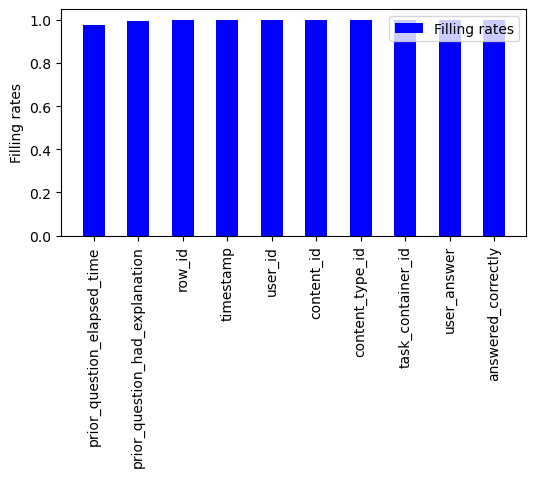

In [15]:
print(train_df.isnull().sum())
print("****************************************")
print(train_df.isnull().sum() / len(train_df))

print_filling_rate (train_df, True, "blue", "blue")

Distribution of questions and lectures content_type :

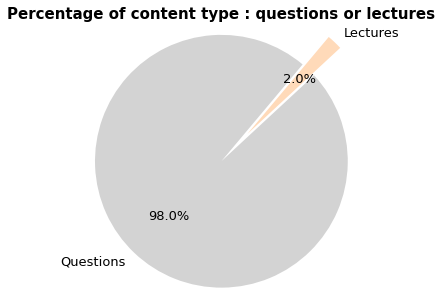

   content_type_id
0           980093
1            19907


In [16]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.title('Percentage of content type : questions or lectures', fontsize=15, weight="bold")
labels = ['Questions','Lectures']
colors = ['lightgray','peachpuff']
explode=(0.1,0.2 )
train_df["content_type_id"].value_counts(normalize=True).plot(kind='pie', labels=labels, colors=colors, explode=explode, startangle=50, autopct='%1.1f%%', fontsize = 13)
plt.axis('equal') 
plt.ylabel('')
plt.show()

print(train_df['content_type_id'].value_counts().sort_index().to_frame())

The majority of the users interactions are <span style="color:magenta">**questions**</span> : 98% VS 2% for lectures.

In [17]:
%%time

questions_df = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/questions.csv')


CPU times: user 11.7 ms, sys: 1.98 ms, total: 13.7 ms
Wall time: 12.6 ms


## Merge of train_df and questions_df

In [18]:
train_questions_df = pd.merge(train_df[train_df['content_type_id']==0],questions_df, how='left', left_on='content_id', right_on='question_id').sort_values('row_id')

In [19]:
train_questions_df.columns

Index(['row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id',
       'task_container_id', 'user_answer', 'answered_correctly',
       'prior_question_elapsed_time', 'prior_question_had_explanation',
       'question_id', 'bundle_id', 'correct_answer', 'part', 'tags'],
      dtype='object')

In [20]:
train_questions_df.describe()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,question_id,bundle_id,correct_answer,part
count,980093.000000,9.800930e+05,9.800930e+05,980093.000000,980093.0,980093.000000,980093.000000,980093.000000,976277.000000,980093.000000,980093.000000,980093.000000,980093.000000
mean,499834.496477,7.333085e+09,1.016903e+07,5000.238626,0.0,808.009877,1.423019,0.650358,25319.472656,5000.238626,4999.823346,1.438840,4.100419
std,288717.979156,1.057230e+10,6.030037e+06,3287.211531,0.0,1029.988408,1.156775,0.476857,19707.429688,3287.211531,3287.092819,1.154287,1.674208
min,0.000000,0.000000e+00,1.150000e+02,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,249689.000000,5.169283e+08,4.700718e+06,1999.000000,0.0,107.000000,0.000000,0.000000,16000.000000,1999.000000,1997.000000,0.000000,2.000000
50%,499927.000000,2.805786e+09,9.678259e+06,4996.000000,0.0,390.000000,1.000000,1.000000,21000.000000,4996.000000,4996.000000,1.000000,5.000000
75%,750057.000000,1.010340e+10,1.556872e+07,7218.000000,0.0,1115.000000,3.000000,1.000000,29666.000000,7218.000000,7216.000000,3.000000,5.000000
max,999999.000000,7.809200e+10,2.094902e+07,13522.000000,0.0,7739.000000,3.000000,1.000000,300000.000000,13522.000000,13522.000000,3.000000,7.000000


In [21]:
print("The dataset contains {} rows and {} columns. \n".format(train_questions_df.shape[0], train_questions_df.shape[0]))
for col in train_questions_df:
    print("The column {} has {} unique values.".format(col, train_questions_df[col].nunique()))

The dataset contains 980093 rows and 980093 columns. 

The column row_id has 980093 unique values.
The column timestamp has 749458 unique values.
The column user_id has 3824 unique values.
The column content_id has 13076 unique values.
The column content_type_id has 1 unique values.
The column task_container_id has 7740 unique values.
The column user_answer has 4 unique values.
The column answered_correctly has 2 unique values.
The column prior_question_elapsed_time has 1659 unique values.
The column prior_question_had_explanation has 2 unique values.
The column question_id has 13076 unique values.
The column bundle_id has 9527 unique values.
The column correct_answer has 4 unique values.
The column part has 7 unique values.
The column tags has 1501 unique values.


## Users

3 824 unique users



In [22]:
nb_questions_per_user = train_questions_df[['user_id','row_id']].\
                                 groupby(['user_id'],as_index = False).\
                                 agg(['count']).reset_index()

nb_questions_per_user.columns = ["user_id","nb_questions"]

print("Mean : {}".format(nb_questions_per_user["nb_questions"].mean()))
print("Min : {}".format(nb_questions_per_user["nb_questions"].min()))
print("Max : {}".format(nb_questions_per_user["nb_questions"].max()))
print("Median : {}".format(nb_questions_per_user["nb_questions"].median()))

Mean : 256.30047071129707
Min : 1
Max : 10797
Median : 41.0



Median is 41. 50% of the users has answer at 41 or less questions. 

Max = 10797. Mean (=10797) is sensible at the outliers.

Let have a look at the distribution of the number of question by user :

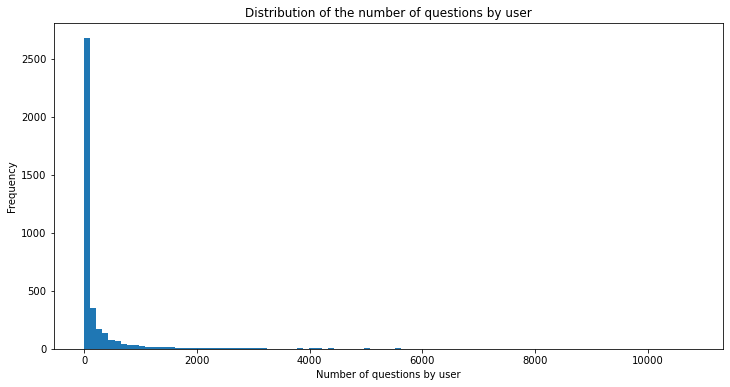

In [23]:
fig = plt.figure(figsize=(12,6))
nb_questions_per_user['nb_questions'].plot.hist(bins=100)
plt.title("Distribution of the number of questions by user")
plt.xticks(rotation=0)
plt.xlabel("Number of questions by user")
plt.show()

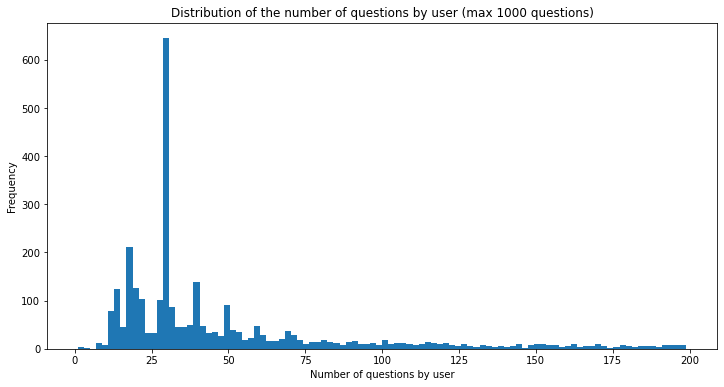

In [24]:
fig = plt.figure(figsize=(12,6))
nb_questions_per_user[nb_questions_per_user['nb_questions']<200]['nb_questions'].plot.hist(bins=100)
plt.title("Distribution of the number of questions by user (max 1000 questions)")
plt.xticks(rotation=0)
plt.xlabel("Number of questions by user")
plt.show()

In [25]:
del nb_questions_per_user
gc.collect()

12264

In [26]:
# Check if we have the same result if we calculate if the answer is correct and the target
user_accuracy_df = train_questions_df[['user_id', 'user_answer', 'correct_answer','answered_correctly']]

user_accuracy_df['answered_correctly_calc']= user_accuracy_df['user_answer'] - user_accuracy_df['correct_answer']

user_accuracy_df['different_result'] = 1
user_accuracy_df.loc[user_accuracy_df['answered_correctly_calc'] != 0, 'different_result'] =0
user_accuracy_df['is_different_result'] = user_accuracy_df['different_result'] - user_accuracy_df['answered_correctly']


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [27]:
print(user_accuracy_df['is_different_result'].sum())

0


The columns 'user_answer' is just here for information, maybe we can find a pattern : when the user doesn't know the answer, he uses to choose the same answer.
Or maybe the question has a subtlety and students with a lower level do the same error, that can help to detect a misunderstood and propose a solution to help students, ...

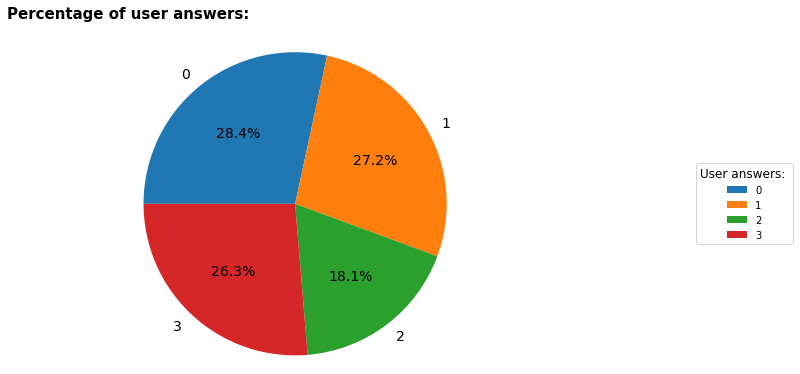

0    278205
1    267017
3    257932
2    176939
Name: user_answer, dtype: int64


In [28]:
print_pie(user_accuracy_df, 'user_answer', "Percentage of user answers:", "User answers: ")
print(user_accuracy_df.user_answer.value_counts())

The user answers are 0, 1, 2 or 3. But what means 0 : is it a possible answer, or does it mean "no answer" ? 
Let have a look at the possible answers (in questions_df) :

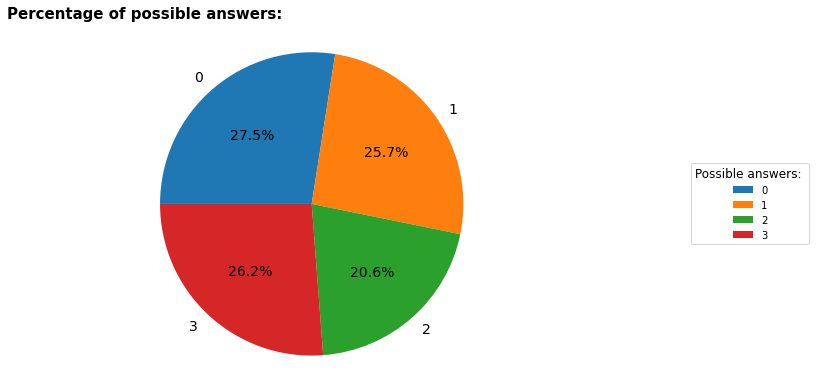

In [29]:
print_pie(questions_df, 'correct_answer', "Percentage of possible answers:", "Possible answers: ")

Ok, 0 is a possible answer.

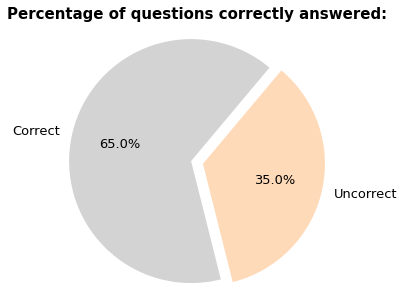

   answered_correctly
0              342682
1              637411


In [21]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.title('Percentage of questions correctly answered:', fontsize=15, weight="bold")
labels = ['Correct', 'Uncorrect']
colors = ['lightgray','peachpuff']
explode=(0.1,0)
user_accuracy_df["answered_correctly"].\
                value_counts(normalize=True).\
                plot(kind='pie', labels=labels, colors=colors, explode=explode,
                     startangle=50, autopct='%1.1f%%', fontsize = 13)
plt.axis('equal') 
plt.ylabel('')
plt.show()

print(user_accuracy_df['answered_correctly'].value_counts().sort_index().to_frame())

In [22]:
del user_accuracy_df
gc.collect()

13609

In [23]:
train_questions_df.columns

Index(['row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id',
       'task_container_id', 'user_answer', 'answered_correctly',
       'prior_question_elapsed_time', 'prior_question_had_explanation',
       'question_id', 'bundle_id', 'correct_answer', 'part', 'tags'],
      dtype='object')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


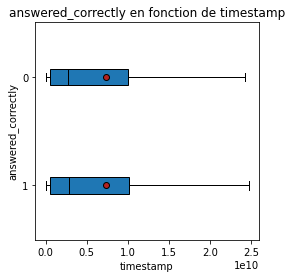

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


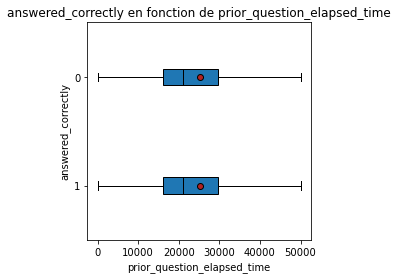

4817

In [24]:
X = "answered_correctly" # qualitative
data_df = train_questions_df[~train_questions_df['prior_question_elapsed_time'].isna()].sort_index()


modalites = np.sort(data_df[X].unique())
modalites = modalites[::-1]

list_columns = ['timestamp', 'prior_question_elapsed_time']

for column in list_columns:
    Y = column
    fig, ax = plt.subplots(figsize=(4, 4))
    groupes = []
    for m in modalites:
        groupes.append(data_df[(train_df[X]==m) & (~(train_df[Y].isna()))][Y])   
    medianprops = {'color':"black"}
    meanprops = {'marker':'o', 'markeredgecolor':'black',
                'markerfacecolor':'firebrick'}
    plt.title(X + ' en fonction de '+column)
    plt.ylabel(X)
    plt.xlabel(column)    
    plt.boxplot(groupes, labels=modalites, showfliers=False, 
                medianprops=medianprops, vert=False, 
                patch_artist=True, showmeans=True, meanprops=meanprops)
    plt.show()
    
del data_df
gc.collect()

### The part of questions : 

In [25]:
answer_part_df = train_questions_df[['part', 'answered_correctly']].\
                                 groupby(['part'],as_index = False).\
                                 agg(['mean']).reset_index()
answer_part_df.columns = ["part", 'answered_correctly_mean']

In [26]:
answer_part_df

,part,answered_correctly_mean
0,1,0.735834
1,2,0.707258
2,3,0.692096
3,4,0.620959
4,5,0.606321
5,6,0.650695
6,7,0.645141


The Toeic has 2 sections : Listening (part 1 -> 4) and Reading (part 5 -> 7)
The section listening seems to be easy than the reading section.
Parts 1-> 3 are the easiest parts. Parts 4 and 5 the more difficult.

In [27]:
del answer_part_df
gc.collect()

60

In [28]:
answer_nb_bundle_by_part_df = questions_df[['part', 'bundle_id']].\
                                 groupby(['part'],as_index = False).\
                                 agg(['count']).reset_index()
answer_nb_bundle_by_part_df.columns = ["part", 'nb_bundle']
answer_nb_bundle_by_part_df

,part,nb_bundle
0,1,992
1,2,1647
2,3,1562
3,4,1439
4,5,5511
5,6,1212
6,7,1160


We have between 992 and 5511 possible bundles of questions by part.

In [29]:
answer_nb_part_by_bundly_df = questions_df[['bundle_id', 'part']]
answer_nb_part_by_bundly_df.drop_duplicates(keep = 'first', inplace=True)

result_nb_part_by_bundle = answer_nb_part_by_bundly_df.groupby(['bundle_id'],as_index = False).agg(['count']).reset_index()
result_nb_part_by_bundle.columns = ["bundle_id", 'nb_part']
result_nb_part_by_bundle.describe()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,bundle_id,nb_part
count,9765.000000,9765.0
mean,6733.793344,1.0
std,3915.523969,0.0
min,0.000000,1.0
25%,3873.000000,1.0
50%,6314.000000,1.0
75%,9847.000000,1.0
max,13522.000000,1.0


One part can have several bundles.
But one bundle belongs to only one part.

In [30]:
del answer_nb_part_by_bundly_df
del result_nb_part_by_bundle
gc.collect()

20

In [31]:
answer_bundle_df = train_questions_df[['bundle_id', 'part', 'answered_correctly']].\
                                 groupby(['bundle_id', 'part'],as_index = False).\
                                 agg(['mean']).reset_index()
answer_bundle_df.columns = ["bundle_id", "part", 'answered_correctly_mean']

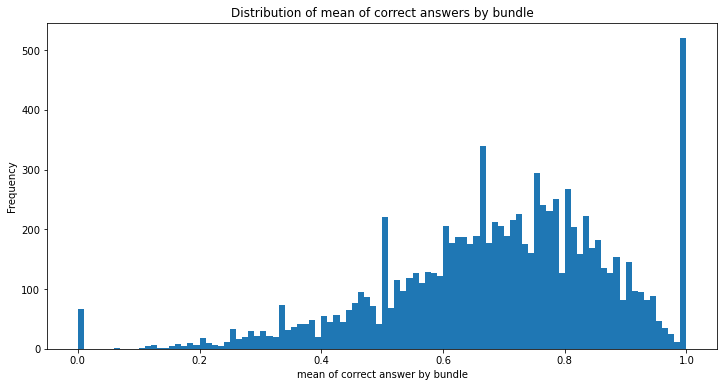

In [32]:
fig = plt.figure(figsize=(12,6))
answer_bundle_df['answered_correctly_mean'].plot.hist(bins=100)
plt.title("Distribution of mean of correct answers by bundle")
plt.xticks(rotation=0)
plt.xlabel("mean of correct answer by bundle")
plt.show()

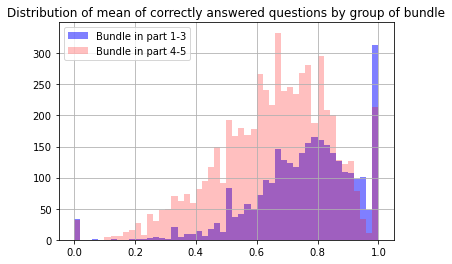

In [33]:
import numpy as np
import matplotlib.pyplot as plt

plt.hist(answer_bundle_df[answer_bundle_df['part']<4]['answered_correctly_mean'], bins=50, color="blue", alpha=0.5, label='Bundle in part 1-3')
plt.hist(answer_bundle_df[(answer_bundle_df['part']>=4)&(answer_bundle_df['part']<6)]['answered_correctly_mean'], bins=50, color="red", alpha=0.25, label='Bundle in part 4-5')
plt.legend(loc='upper left')

plt.title('Distribution of mean of correctly answered questions by group of bundle')
plt.grid()

plt.show()

In [34]:
del answer_bundle_df
gc.collect()

9435

## timestamp

In [35]:
user_timestamp_df = train_df[['user_id', 'timestamp']].\
                                 groupby(['user_id'],as_index = False).\
                                 agg(['max','min','mean']).reset_index()
user_timestamp_df.columns = ["user_id", 'max_timestamp', 'min_timestamp', 'mean_timestamp']

In [36]:
user_timestamp_df.describe()

,user_id,max_timestamp,min_timestamp,mean_timestamp
count,3.824000e+03,3.824000e+03,3824.0,3.824000e+03
mean,1.050633e+07,5.350710e+09,0.0,2.344138e+09
std,5.958653e+06,1.071450e+10,0.0,5.686709e+09
min,1.150000e+02,0.000000e+00,0.0,0.000000e+00
25%,5.363199e+06,1.129642e+06,0.0,5.340352e+05
50%,1.061051e+07,3.503858e+08,0.0,1.366477e+08
75%,1.565077e+07,5.030495e+09,0.0,1.776296e+09
max,2.094902e+07,7.809200e+10,0.0,6.508467e+10


The min timestamp is 0. So we should have the history of interactions from the first interaction.

'timestamp' is in milliseconds. It is difficult for human to have an idea about how long are this periods with this unity. We will convert it in month and observe if it easier to represent this periods.

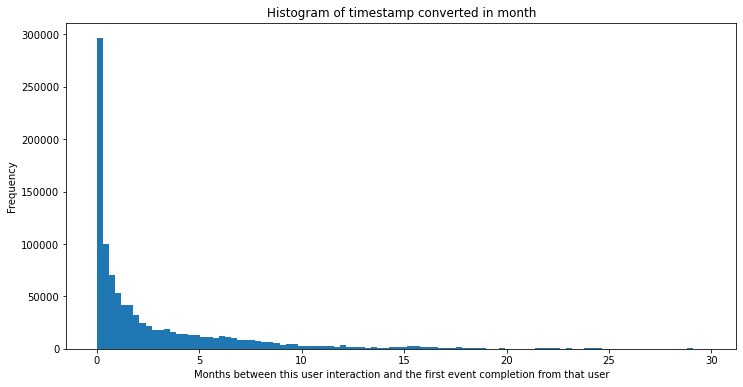

In [37]:
train_df['timestamp_by_month'] = train_df['timestamp']/(1000 * 60 * 60 * 24 * 365)*12
fig = plt.figure(figsize=(12,6))
train_df['timestamp_by_month'].plot.hist(bins=100)
plt.title("Histogram of timestamp converted in month")
plt.xticks(rotation=0)
plt.xlabel("Months between this user interaction and the first event completion from that user")
plt.show()

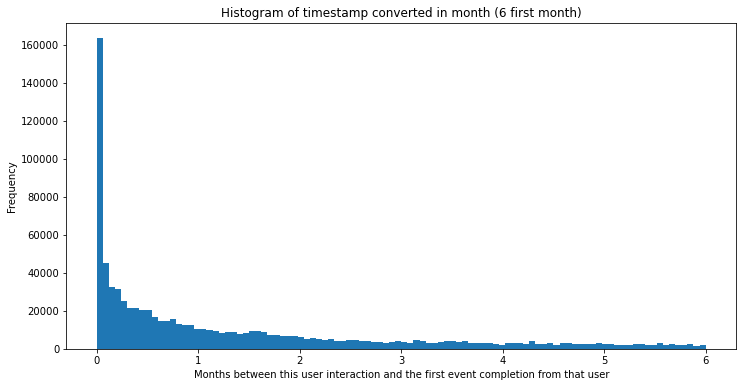

In [38]:
fig = plt.figure(figsize=(12,6))
train_df[train_df['timestamp_by_month']<6]['timestamp_by_month'].plot.hist(bins=100)
plt.title("Histogram of timestamp converted in month (6 first month)")
plt.xticks(rotation=0)
plt.xlabel("Months between this user interaction and the first event completion from that user")
plt.show()

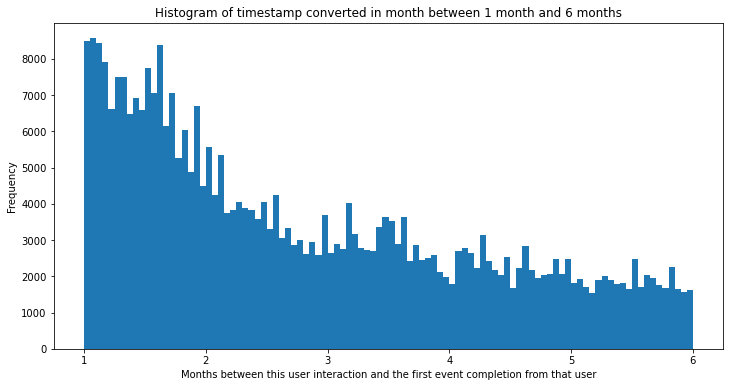

In [39]:
fig = plt.figure(figsize=(12,6))
train_df[(train_df['timestamp_by_month']>=1) & (train_df['timestamp_by_month']<6)]['timestamp_by_month'].plot.hist(bins=100)
plt.title("Histogram of timestamp converted in month between 1 month and 6 months")
plt.xticks(rotation=0)
plt.xlabel("Months between this user interaction and the first event completion from that user")
plt.show()

In [40]:
user_timestamp_df['max_timestamp_in month'] = user_timestamp_df['max_timestamp']/(1000*60*60*24*365)*12
#.columns = ["user_id", 'max_timestamp', 'min_timestamp', 'mean_timestamp']

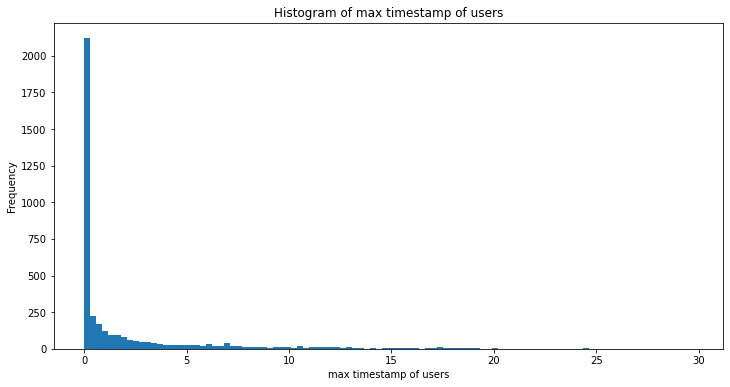

In [41]:

fig = plt.figure(figsize=(12,6))
(user_timestamp_df["max_timestamp"]/1000/60/60/24/365*12).plot.hist(bins=100)
plt.title("Histogram of max timestamp of users")
plt.xticks(rotation=0)
plt.xlabel("max timestamp of users")
plt.show()

### Prior questions have explanation

In [ ]:
train_df['prior_question_had_explanation'].fillna(False, inplace=True)
train_df.loc[train_df["prior_question_had_explanation"]== True, "prior_had_explanation_le"] = 1
train_df.loc[train_df["prior_question_had_explanation"]== False, "prior_had_explanation_le"] = 0

KeyError: 'prior_had_explanation_le'

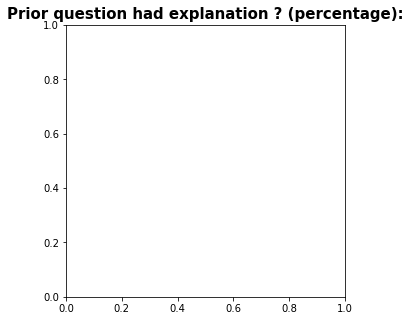

In [30]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.title('Prior question had explanation ? (percentage):', fontsize=15, weight="bold")
labels = ['Yes', 'No']
colors = ['lightgray','peachpuff']
explode=(0.1,0)
train_df["prior_had_explanation_le"].value_counts(normalize=True).plot(kind='pie', labels=labels, colors=colors, explode=explode, startangle=50, autopct='%1.1f%%', fontsize = 13)
plt.axis('equal') 
plt.ylabel('')
plt.show()

print(train_df['prior_had_explanation_le'].value_counts().sort_index().to_frame())

## Tags

In code available on github, we can learn tags are chosen by experts.
So what can we learn on them ?

In [56]:
questions_df['tags'].fillna("", inplace=True)
questions_df["nb_tags"] = questions_df["tags"].apply(lambda text: len(text.split()))

questions_df["nb_tags"].describe()

count    13523.000000
mean         2.291799
std          1.369868
min          0.000000
25%          1.000000
50%          3.000000
75%          3.000000
max          6.000000
Name: nb_tags, dtype: float64

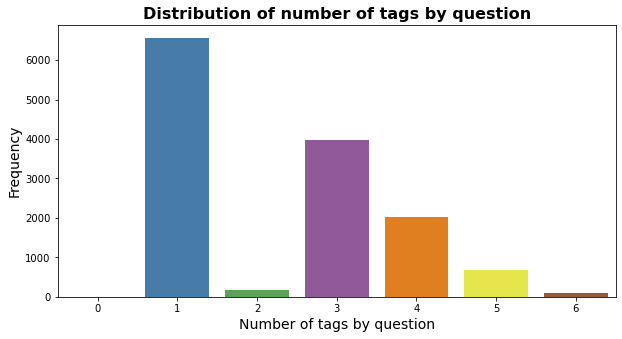

In [55]:
import matplotlib.style as style
style.use('seaborn-dark-palette')
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("Distribution of number of tags by question", fontsize=15, weight="bold");

sns.countplot(questions_df['nb_tags'], palette="Set1")
ax.set_ylabel("Frequency", fontsize=14)
ax.set_xlabel("Number of tags by question", fontsize=14);

Create 2 lists : 
* with all tags of all questions (a same tag can appear several times in this list)
* with unique tags. A same tag can appear only one time).

In [59]:
questions_df['tags_list'] = questions_df['tags'].apply(lambda x: x.split())

# List with all tags 
tags_list = [item for sublist in questions_df['tags_list'].values for item in sublist]
print('{} tags are used in questions.'.format(len(tags_list)))

# List of unique tags
tags_unique_list = list(set(tags_list))
print('There are {} unique tags.'.format(len(tags_unique_list)))

30992 tags are used in questions.
There are 188 unique tags.


### Are we use few tags or all of tags ?

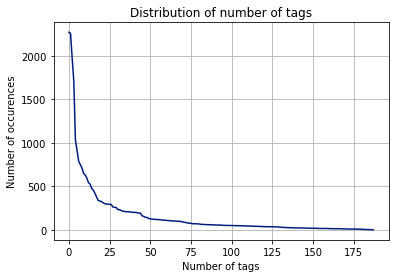

In [64]:
tags_frequence= nltk.FreqDist(tags_list)

plot_distribution_of_number_of_tags(len(tags_unique_list), False)

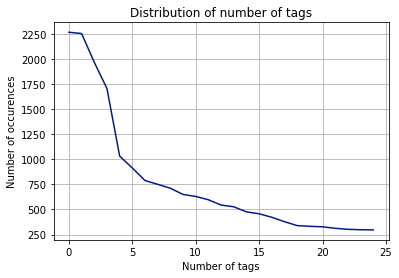

In [65]:
plot_distribution_of_number_of_tags(25, False)

Which tags are the 10 most frequent tags?

In [67]:
words_most_common = tags_frequence.most_common(10)
fq_words_df = pd.DataFrame(words_most_common, columns = ['tags' , 'nb_tags']) 
print((fq_words_df['tags'][:10]).to_list())

del fq_words_df
gc.collect()

['92', '38', '81', '29', '136', '162', '102', '8', '143', '131']


16887

**To be continious !! Do you have some comments ?**